<a href="https://colab.research.google.com/github/carahul0007/AI-ML-in-Financial-Services-Project--Prediction-of-IPO-success-/blob/main/bits_project_ana.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install libraries if missing
!pip install textblob xgboost shap --quiet

# Import core packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import roc_auc_score, classification_report, mean_squared_error, r2_score
from xgboost import XGBClassifier, XGBRegressor
import shap


In [ ]:
# Replace with your uploaded filenames
fin = pd.read_excel("sentiment.xlsx")      # Financial data
news = pd.read_csv("news.csv")             # Google News data
reddit = pd.read_csv("reddit.csv")         # Reddit data

print("Financial data:", fin.shape)
print("News data:", news.shape)
print("Reddit data:", reddit.shape)

fin.head(), news.head(), reddit.head()


Financial data: (21, 18)
News data: (1943, 5)
Reddit data: (431, 7)


(                                          Unnamed: 0 Unnamed: 1 Unnamed: 2  \
 0                                        Name of IPO   Firm Age  Firm Size   
 1  UrbanClap Technologies India Limited (Urban Co...         11       2210   
 2  SolarWorld Energy Solutions Ltd. (SolarWorld E...         12        598   
 3  Seshaasai Technologies Ltd. (Seshaasai Technol...         32       1160   
 4  Anand Rathi Share and Stock Brokers Ltd. (Anan...         34       3344   
 
        Unnamed: 3 Unnamed: 4 Unnamed: 5 Unnamed: 6     Unnamed: 7  \
 0  Revenue Growth        ROA   PE ratio   Leverage  Current Ratio   
 1         0.38164     12.4 %        105        120           2.67   
 2          0.0878      0.204       37.7        115           1.94   
 3         -0.0673      0.211       30.9        379           1.78   
 4          0.2394      0.035       27.8        914           1.33   
 
      Unnamed: 8          Unnamed: 9 Unnamed: 10     Unnamed: 11  Unnamed: 12  \
 0  Cash Holding  Pro

In [ ]:
# Read the Excel file again, specifying the header row and skipping the initial descriptive row
fin = pd.read_excel("sentiment.xlsx", header=0, skiprows=[1])


# Clean and convert columns
for col in fin.columns:
    # Ensure column is string type before cleaning
    fin[col] = fin[col].astype(str)
    # Remove percentage signs, commas, spaces, etc.
    fin[col] = fin[col].str.replace('%','', regex=False).str.replace(',','', regex=False).str.strip()
    # Attempt to convert to numeric
    fin[col] = pd.to_numeric(fin[col], errors='coerce')


fin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   0 non-null      float64
 1   Unnamed: 1   20 non-null     int64  
 2   Unnamed: 2   15 non-null     float64
 3   Unnamed: 3   14 non-null     float64
 4   Unnamed: 4   15 non-null     float64
 5   Unnamed: 5   15 non-null     float64
 6   Unnamed: 6   16 non-null     float64
 7   Unnamed: 7   14 non-null     float64
 8   Unnamed: 8   15 non-null     float64
 9   Unnamed: 9   15 non-null     float64
 10  Unnamed: 10  17 non-null     float64
 11  Unnamed: 11  11 non-null     float64
 12  Unnamed: 12  0 non-null      float64
 13  Unnamed: 13  8 non-null      float64
 14  Unnamed: 14  1 non-null      float64
 15  Unnamed: 15  13 non-null     float64
 16  Unnamed: 16  0 non-null      float64
 17  Unnamed: 17  1 non-null      float64
dtypes: float64(17), int64(1)
memory usage: 2.9 KB


In [ ]:
# --- Google News ---
if 'Title' in news.columns:
    news['Title'] = news['Title'].astype(str)
    news['news_polarity'] = news['Title'].apply(lambda x: TextBlob(x).sentiment.polarity)
else:
    news['news_polarity'] = np.nan

# --- Reddit ---
text_col = None
for c in reddit.columns:
    if any(k in c.lower() for k in ['title','body','text','comment']):
        text_col = c
        break

reddit[text_col] = reddit[text_col].astype(str)
reddit['reddit_polarity'] = reddit[text_col].apply(lambda x: TextBlob(x).sentiment.polarity)


In [ ]:
news_agg = news.groupby('Company', as_index=False).agg(
    news_polarity_mean=('news_polarity','mean'),
    news_mentions=('news_polarity','count')
)

reddit_agg = reddit.groupby('Company', as_index=False).agg(
    reddit_polarity_mean=('reddit_polarity','mean'),
    reddit_mentions=('reddit_polarity','count'),
    reddit_score_mean=('Score','mean')
)

news_agg.head(), reddit_agg.head()


(                              Company  news_polarity_mean  news_mentions
 0  Aarvee Engineering Consultants IPO            0.089977            143
 1                    Ather Energy IPO            0.096577            200
 2                     Deon Energy IPO            0.028890            200
 3                    Hero FinCorp IPO            0.054243            200
 4                    Infra.Market IPO            0.079041            200,
                               Company  reddit_polarity_mean  reddit_mentions  \
 0  Aarvee Engineering Consultants IPO             -0.036111                6   
 1                    Ather Energy IPO              0.053999              100   
 2                     Deon Energy IPO              0.053999              100   
 3                    Hero FinCorp IPO              0.000000                6   
 4                    Infra.Market IPO              0.366667                3   
 
    reddit_score_mean  
 0         253.333333  
 1         391.4100

In [ ]:
import pandas as pd

# Backtesting dataset (with full info)
fin_backtest = pd.read_excel("/content/fin ipo back test.xlsx", header=0, skiprows=[1])

# Prediction dataset (missing target values)
fin_predict = pd.read_excel("/content/fin ipo prediction.xlsx", header=0, skiprows=[1])

# Clean column names and standardize IPO name column
for df in [fin_backtest, fin_predict]:
    # Clean column names by stripping whitespace and replacing spaces with underscores
    df.columns = df.columns.str.strip().str.replace('%','').str.replace(' ','_').str.replace('\xa0','').str.lower()
    # Display columns after cleaning for debugging
    print("Columns after cleaning:", df.columns.tolist())
    # Standardize the IPO name column - using the correct cleaned name 'ipo_name'
    df['ipo_name'] = df['ipo_name'].astype(str).str.lower().str.strip()


print("✅ Backtest file shape:", fin_backtest.shape)
print("✅ Prediction file shape:", fin_predict.shape)
print("\nBacktest columns:\n", fin_backtest.columns.tolist())

Columns after cleaning: ['ipo_name', 'firm_age', 'firm_size', 'revenue_growth', 'roa', 'pe_ratio', 'leverage', 'current_ratio', 'cash_holding', "promoter's_holding", 'issue_size', 'offer_price_rs', 'price_range', 'over_subscrition_ratio', 'listing_price', 'listing_gain']
Columns after cleaning: ['ipo_name', 'firm_age', 'firm_size', 'revenue_growth', 'roa', 'pe_ratio', 'leverage', 'current_ratio', 'cash_holding', "promoter's_holding", 'issue_size', 'offer_price_rs', 'price_range', 'over_subscrition_ratio', 'listing_price', 'listing_gain']
✅ Backtest file shape: (11, 16)
✅ Prediction file shape: (6, 16)

Backtest columns:
 ['ipo_name', 'firm_age', 'firm_size', 'revenue_growth', 'roa', 'pe_ratio', 'leverage', 'current_ratio', 'cash_holding', "promoter's_holding", 'issue_size', 'offer_price_rs', 'price_range', 'over_subscrition_ratio', 'listing_price', 'listing_gain']


In [ ]:
data = fin_backtest.merge(news_agg, left_on='ipo_name', right_on='Company', how='left')\
                   .merge(reddit_agg, left_on='ipo_name', right_on='Company', how='left', suffixes=('','_r'))


In [ ]:
# Run this cell to diagnose missing files, attempt to load them, build data_backtest and impute sentiment NaNs.
import os, glob, pandas as pd, numpy as np, textwrap
from textblob import TextBlob
np.random.seed(42)

print("Working directory:", os.getcwd())
print("\nFiles in working directory (top 200):")
for i, f in enumerate(sorted(os.listdir('.'))[:200]):
    print(f"  {i+1:03d}. {f}")

# Search for likely files with flexible patterns
candidates = {
    "fin_backtest": ["fin ipo back test.xlsx", "fin_ipo_back_test.xlsx", "fin ipo backtest.xlsx", "fin_backtest.xlsx", "fin ipo back test.xls", "fin ipo back test.csv"],
    "news": ["news.csv", "news_data.csv", "google_news.csv"],
    "reddit": ["reddit.csv", "reddit_data.csv"]
}

found = {}
for key, patterns in candidates.items():
    found[key] = None
    for p in patterns:
        if os.path.exists(p):
            found[key] = p
            break
    # also try glob wildcards
    if found[key] is None:
        for patt in patterns:
            for match in glob.glob(f"*{patt}*"):
                found[key] = match
                break
            if found[key] is not None:
                break

print("\nCandidate files found:")
for k,v in found.items():
    print(f"  {k}: {v}")

# If we didn't find required files, show helpful upload instructions
missing = [k for k,v in found.items() if v is None]
if missing:
    print("\nERROR: The following required source files were NOT found in the working directory:")
    for m in missing:
        print("   -", m)
    print(textwrap.dedent("""
    To proceed, either:
    1) Upload the missing files using Colab's left pane: Files → Upload (drag-and-drop), OR
    2) Mount Google Drive and place files there, then use the path '/content/drive/MyDrive/your_folder/filename'.

    Common filenames to upload (examples from this project):
      - fin ipo back test.xlsx
      - news.csv
      - reddit.csv

    After uploading, rerun this cell.
    """))
    # stop here because necessary files are missing
else:
    # All candidate files found; attempt to load them and create data_backtest
    fb_path = found['fin_backtest']
    news_path = found['news']
    reddit_path = found['reddit']
    print("\nAttempting to load files:")
    print("  fin_backtest:", fb_path)
    print("  news:", news_path)
    print("  reddit:", reddit_path)
    try:
        fin_backtest = pd.read_excel(fb_path, header=0, skiprows=[1])
        print("Loaded fin_backtest:", fin_backtest.shape)
    except Exception as e:
        print("Failed to read fin_backtest:", e)
        raise

    try:
        news = pd.read_csv(news_path)
        print("Loaded news:", news.shape)
    except Exception as e:
        print("Failed to read news.csv:", e)
        raise

    try:
        reddit = pd.read_csv(reddit_path)
        print("Loaded reddit:", reddit.shape)
    except Exception as e:
        print("Failed to read reddit.csv:", e)
        raise

    # Recreate news_agg and reddit_agg robustly
    # News polarity
    if 'Title' in news.columns:
        news['Title'] = news['Title'].astype(str)
        news['news_polarity'] = news['Title'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
    else:
        # try first text-like column
        textcol = news.columns[0]
        news[textcol] = news[textcol].astype(str)
        news['news_polarity'] = news[textcol].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
    # detect company/ipo col
    ipo_col_news = None
    for c in news.columns:
        if any(k in c.lower() for k in ['ipo','company','name']):
            ipo_col_news = c
            break
    if ipo_col_news is None:
        ipo_col_news = 'Company'
        news[ipo_col_news] = news.iloc[:,0].astype(str)
    news_agg = news.groupby(ipo_col_news, as_index=False).agg(
        news_polarity_mean=('news_polarity','mean'),
        news_mentions=('news_polarity','count')
    ).rename(columns={ipo_col_news:'Company'})
    print("Constructed news_agg with shape:", news_agg.shape)

    # Reddit polarity
    text_col = None
    score_col = None
    for c in reddit.columns:
        if any(k in c.lower() for k in ['title','body','text','comment','post']):
            text_col = c
        if 'score' in c.lower():
            score_col = c
    if text_col is None:
        text_col = reddit.columns[0]
        reddit[text_col] = reddit[text_col].astype(str)
    reddit['reddit_polarity'] = reddit[text_col].astype(str).apply(lambda x: TextBlob(str(x)).sentiment.polarity)
    if score_col is None:
        reddit['reddit_score'] = np.nan
    else:
        reddit['reddit_score'] = reddit[score_col]
    ipo_col_reddit = None
    for c in reddit.columns:
        if any(k in c.lower() for k in ['ipo','company','name']):
            ipo_col_reddit = c
            break
    if ipo_col_reddit is None:
        ipo_col_reddit = 'Company'
        reddit[ipo_col_reddit] = reddit.iloc[:,0].astype(str)
    reddit_agg = reddit.groupby(ipo_col_reddit, as_index=False).agg(
        reddit_polarity_mean=('reddit_polarity','mean'),
        reddit_mentions=('reddit_polarity','count'),
        reddit_score_mean=('reddit_score','mean')
    ).rename(columns={ipo_col_reddit:'Company'})
    print("Constructed reddit_agg with shape:", reddit_agg.shape)

    # Clean fin_backtest column names and create ipo_name
    fin_backtest.columns = fin_backtest.columns.str.strip().str.replace('%','').str.replace(' ','_').str.replace('\xa0','').str.lower()
    if 'ipo_name' not in fin_backtest.columns:
        # try to find a column that looks like IPO name
        ipo_col_guess = None
        for c in fin_backtest.columns:
            if any(k in c for k in ['ipo','name','company']):
                ipo_col_guess = c
                break
        if ipo_col_guess is None:
            raise RuntimeError("fin_backtest does not contain an 'ipo_name' (or similar) column. Please check your fin_backtest file.")
        fin_backtest['ipo_name'] = fin_backtest[ipo_col_guess].astype(str).str.lower().str.strip()
    else:
        fin_backtest['ipo_name'] = fin_backtest['ipo_name'].astype(str).str.lower().str.strip()

    # lower-case company columns in news/reddit and merge
    news_agg['Company'] = news_agg['Company'].astype(str).str.lower().str.strip()
    reddit_agg['Company'] = reddit_agg['Company'].astype(str).str.lower().str.strip()

    data_backtest = fin_backtest.merge(news_agg, left_on='ipo_name', right_on='Company', how='left')\
                               .merge(reddit_agg, left_on='ipo_name', right_on='Company', how='left', suffixes=('','_r'))
    print("Merged data_backtest shape:", data_backtest.shape)

    # Now impute only sentiment NaNs (same ranges as discussed)
    sent_cols = ['news_polarity_mean','news_mentions','reddit_polarity_mean','reddit_mentions','reddit_score_mean']
    for c in sent_cols:
        if c not in data_backtest.columns:
            data_backtest[c] = np.nan
    # show missing counts BEFORE
    print("\nMissing counts BEFORE imputation:")
    for c in sent_cols:
        print(f"  {c}: {data_backtest[c].isna().sum()}")

    # impute
    def fill_missing_uniform(df, col, low, high, decimals=3):
        idx = df[col].isna()
        n = idx.sum()
        if n>0:
            df.loc[idx, col] = np.round(np.random.uniform(low, high, n), decimals)
        return df
    def fill_missing_int(df, col, low, high):
        idx = df[col].isna()
        n = idx.sum()
        if n>0:
            df.loc[idx, col] = np.random.randint(low, high+1, n)
        return df

    data_backtest = fill_missing_uniform(data_backtest, 'news_polarity_mean', -0.05, 0.25, decimals=3)
    data_backtest = fill_missing_int(data_backtest, 'news_mentions', 10, 150)
    data_backtest = fill_missing_uniform(data_backtest, 'reddit_polarity_mean', -0.10, 0.20, decimals=3)
    data_backtest = fill_missing_int(data_backtest, 'reddit_mentions', 5, 250)
    data_backtest = fill_missing_int(data_backtest, 'reddit_score_mean', 1, 100)

    # after
    print("\nMissing counts AFTER imputation (should be 0):")
    for c in sent_cols:
        print(f"  {c}: {data_backtest[c].isna().sum()}")

    # save
    out_path = "/content/IPO_Backtest_Sentiment_Filled.xlsx"
    data_backtest.to_excel(out_path, index=False)
    print("\nSaved imputed dataset to:", out_path)


Working directory: /content

Files in working directory (top 200):
  001. .config
  002. sample_data

Candidate files found:
  fin_backtest: None
  news: None
  reddit: None

ERROR: The following required source files were NOT found in the working directory:
   - fin_backtest
   - news
   - reddit

To proceed, either:
1) Upload the missing files using Colab's left pane: Files → Upload (drag-and-drop), OR
2) Mount Google Drive and place files there, then use the path '/content/drive/MyDrive/your_folder/filename'.

Common filenames to upload (examples from this project):
  - fin ipo back test.xlsx
  - news.csv
  - reddit.csv

After uploading, rerun this cell.



In [ ]:
import os

print("📂 Current files in /content:")
for f in sorted(os.listdir("/content")):
    print("  ", f)


📂 Current files in /content:
   .config
   .ipynb_checkpoints
   fin ipo back test.xlsx
   fin ipo prediction.xlsx
   new ipo data reddit.csv
   prediction_ipos_GoogleNews.csv
   sample_data


In [ ]:
import pandas as pd

# Load the filled dataset from previous step
data_backtest = pd.read_excel("/content/IPO_Backtest_Sentiment_Filled.xlsx")

print("✅ Loaded filled dataset successfully. Shape:", data_backtest.shape)
print("\nColumns:\n", data_backtest.columns.tolist())

# Quick check of sentiment variables
data_backtest[['ipo_name', 'news_polarity_mean', 'news_mentions', 'reddit_polarity_mean', 'reddit_mentions', 'reddit_score_mean']].head(10)


FileNotFoundError: [Errno 2] No such file or directory: '/content/IPO_Backtest_Sentiment_Filled.xlsx'

In [ ]:
fin_names = set(fin_backtest['ipo_name'].str.lower().str.strip())
news_names = set(news_agg['Company'].str.lower().str.strip())
reddit_names = set(reddit_agg['Company'].str.lower().str.strip())

print("Financial IPOs not found in News sentiment:", fin_names - news_names)
print("Financial IPOs not found in Reddit sentiment:", fin_names - reddit_names)


TypeError: 'NoneType' object is not subscriptable

In [ ]:
!pip install rapidfuzz --quiet

In [ ]:
from rapidfuzz import process, fuzz

def best_match(name, choices, score_cutoff=80):
    match, score, _ = process.extractOne(name, choices, scorer=fuzz.token_sort_ratio)
    return match if score >= score_cutoff else None

# Apply fuzzy matching for Google News and Reddit names
fin_backtest['news_match'] = fin_backtest['ipo_name'].apply(lambda x: best_match(x, news_agg['Company']))
fin_backtest['reddit_match'] = fin_backtest['ipo_name'].apply(lambda x: best_match(x, reddit_agg['Company']))

# Merge again using the best matches
data_merged_fuzzy = fin_backtest.merge(news_agg, left_on='news_match', right_on='Company', how='left')\
                                .merge(reddit_agg, left_on='reddit_match', right_on='Company', how='left', suffixes=('','_r'))

print("✅ New merged shape:", data_merged_fuzzy.shape)
print("Non-null sentiment after fuzzy matching:")
print(" - News polarity:", data_merged_fuzzy['news_polarity_mean'].notna().sum())
print(" - Reddit polarity:", data_merged_fuzzy['reddit_polarity_mean'].notna().sum())

# Check a sample
data_merged_fuzzy[['ipo_name','news_match','news_polarity_mean','reddit_match','reddit_polarity_mean']].head(10)


✅ New merged shape: (11, 25)
Non-null sentiment after fuzzy matching:
 - News polarity: 0
 - Reddit polarity: 0


,ipo_name,news_match,news_polarity_mean,reddit_match,reddit_polarity_mean
0,solarworld energy solutions ltd. (solarworld e...,None,NaN,None,NaN
1,seshaasai technologies ltd. (seshaasai technol...,None,NaN,None,NaN
2,anand rathi share and stock brokers ltd. (anan...,None,NaN,None,NaN
3,atlanta electricals limited (atlanta electrica...,None,NaN,None,NaN
4,safe enterprises retail fixtures ltd. (safe en...,None,NaN,None,NaN
5,pushpa jewellers ltd. (pushpa jewellers ipo),None,NaN,None,NaN
6,ecoline exim ltd. (ecoline exim ipo),None,NaN,None,NaN
7,bharatrohan airborne innovations ltd. (bharatr...,None,NaN,None,NaN
8,lg electronics india pvt. ltd. (lg electronics...,None,NaN,None,NaN
9,wework india management pvt. ltd. (wework indi...,None,NaN,None,NaN


In [ ]:
def best_match(name, choices, score_cutoff=60):  # lowered from 80
    match, score, _ = process.extractOne(name, choices, scorer=fuzz.token_sort_ratio)
    return match if score >= score_cutoff else None


In [ ]:
# Apply fuzzy matching again with relaxed threshold (60)
fin_backtest['news_match'] = fin_backtest['ipo_name'].apply(lambda x: best_match(x, news_agg['Company']))
fin_backtest['reddit_match'] = fin_backtest['ipo_name'].apply(lambda x: best_match(x, reddit_agg['Company']))

# Merge again using the best matches
data_merged_fuzzy = (
    fin_backtest.merge(news_agg, left_on='news_match', right_on='Company', how='left')
                .merge(reddit_agg, left_on='reddit_match', right_on='Company', how='left', suffixes=('','_r'))
)

print("✅ New merged shape:", data_merged_fuzzy.shape)
print("Non-null sentiment after fuzzy matching:")
print(" - News polarity:", data_merged_fuzzy['news_polarity_mean'].notna().sum())
print(" - Reddit polarity:", data_merged_fuzzy['reddit_polarity_mean'].notna().sum())

# View which IPOs got matched and what scores they received
data_merged_fuzzy[['ipo_name','news_match','news_polarity_mean','reddit_match','reddit_polarity_mean']].head(10)


✅ New merged shape: (11, 25)
Non-null sentiment after fuzzy matching:
 - News polarity: 1
 - Reddit polarity: 1


,ipo_name,news_match,news_polarity_mean,reddit_match,reddit_polarity_mean
0,solarworld energy solutions ltd. (solarworld e...,None,NaN,None,NaN
1,seshaasai technologies ltd. (seshaasai technol...,None,NaN,None,NaN
2,anand rathi share and stock brokers ltd. (anan...,None,NaN,None,NaN
3,atlanta electricals limited (atlanta electrica...,None,NaN,None,NaN
4,safe enterprises retail fixtures ltd. (safe en...,None,NaN,None,NaN
5,pushpa jewellers ltd. (pushpa jewellers ipo),None,NaN,None,NaN
6,ecoline exim ltd. (ecoline exim ipo),None,NaN,None,NaN
7,bharatrohan airborne innovations ltd. (bharatr...,None,NaN,None,NaN
8,lg electronics india pvt. ltd. (lg electronics...,None,NaN,None,NaN
9,wework india management pvt. ltd. (wework indi...,None,NaN,None,NaN


In [ ]:
!pip install rapidfuzz --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 29.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from textblob import TextBlob

# --- Load sentiment datasets ---
# Read files using just filenames, assuming they are in the default directory
news = pd.read_csv("news.csv")
reddit = pd.read_csv("reddit.csv")

# --- Google News Sentiment ---
if 'Title' in news.columns:
    news['Title'] = news['Title'].astype(str)
    news['news_polarity'] = news['Title'].apply(lambda x: TextBlob(x).sentiment.polarity)
else:
    news['news_polarity'] = 0.0

# Try to detect IPO name column
ipo_col_news = None
for c in news.columns:
    if any(k in c.lower() for k in ['ipo','company','name']):
        ipo_col_news = c
        break

news_agg = news.groupby(ipo_col_news, as_index=False).agg(
    news_polarity_mean=('news_polarity','mean'),
    news_mentions=('news_polarity','count')
)
news_agg.rename(columns={ipo_col_news:'Company'}, inplace=True)

# --- Reddit Sentiment ---
text_col_reddit = None
for c in reddit.columns:
    if any(k in c.lower() for k in ['title','body','text','comment','post']):
        text_col_reddit = c
        break

reddit[text_col_reddit] = reddit[text_col_reddit].astype(str)
reddit['reddit_polarity'] = reddit[text_col_reddit].apply(lambda x: TextBlob(x).sentiment.polarity)

score_col = None
for c in reddit.columns:
    if 'score' in c.lower():
        score_col = c
        break

if score_col:
    reddit['reddit_score'] = reddit[score_col]
else:
    reddit['reddit_score'] = np.nan

# Detect IPO/company column in Reddit data
ipo_col_reddit = None
for c in reddit.columns:
    if any(k in c.lower() for k in ['ipo','company','name']):
        ipo_col_reddit = c
        break

reddit_agg = reddit.groupby(ipo_col_reddit, as_index=False).agg(
    reddit_polarity_mean=('reddit_polarity','mean'),
    reddit_mentions=('reddit_polarity','count'),
    reddit_score_mean=('reddit_score','mean')
)
reddit_agg.rename(columns={ipo_col_reddit:'Company'}, inplace=True)

print("✅ Sentiment aggregation completed.")
print("Google News aggregate shape:", news_agg.shape)
print("Reddit aggregate shape:", reddit_agg.shape)

news_agg.head(), reddit_agg.head()

✅ Sentiment aggregation completed.
Google News aggregate shape: (10, 3)
Reddit aggregate shape: (9, 4)


(                              Company  news_polarity_mean  news_mentions
 0  Aarvee Engineering Consultants IPO            0.089977            143
 1                    Ather Energy IPO            0.096577            200
 2                     Deon Energy IPO            0.028890            200
 3                    Hero FinCorp IPO            0.054243            200
 4                    Infra.Market IPO            0.079041            200,
                               Company  reddit_polarity_mean  reddit_mentions  \
 0  Aarvee Engineering Consultants IPO             -0.036111                6   
 1                    Ather Energy IPO              0.053999              100   
 2                     Deon Energy IPO              0.053999              100   
 3                    Hero FinCorp IPO              0.000000                6   
 4                    Infra.Market IPO              0.366667                3   
 
    reddit_score_mean  
 0         253.333333  
 1         391.4100

In [ ]:
# Ensure consistent name format for merging
fin_backtest['ipo_name'] = fin_backtest['ipo_name'].astype(str).str.lower().str.strip()
fin_predict['ipo_name'] = fin_predict['ipo_name'].astype(str).str.lower().str.strip()
news_agg['Company'] = news_agg['Company'].astype(str).str.lower().str.strip()
reddit_agg['Company'] = reddit_agg['Company'].astype(str).str.lower().str.strip()

# Merge backtest data
data_backtest = fin_backtest.merge(news_agg, left_on='ipo_name', right_on='Company', how='left')\
                            .merge(reddit_agg, left_on='ipo_name', right_on='Company', how='left', suffixes=('','_r'))

# Merge prediction data
data_predict = fin_predict.merge(news_agg, left_on='ipo_name', right_on='Company', how='left')\
                          .merge(reddit_agg, left_on='ipo_name', right_on='Company', how='left', suffixes=('','_r'))

print("✅ Backtest merged shape:", data_backtest.shape)
print("✅ Prediction merged shape:", data_predict.shape)

# Preview merged data
data_backtest.head()


✅ Backtest merged shape: (11, 23)
✅ Prediction merged shape: (6, 23)


,ipo_name,firm_age,firm_size,revenue_growth,roa,pe_ratio,leverage,current_ratio,cash_holding,promoter's_holding,...,over_subscrition_ratio,listing_price,listing_gain,Company,news_polarity_mean,news_mentions,Company_r,reddit_polarity_mean,reddit_mentions,reddit_score_mean
0,solarworld energy solutions ltd. (solarworld e...,12,6.393591,0.0878,0.204,37.7,115.00,1.94,127.00,0.657,...,68.49,388.5,0.106838,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,seshaasai technologies ltd. (seshaasai technol...,32,7.056175,-0.0673,0.211,30.9,379.00,1.78,128.00,0.818,...,122.06,436.0,0.030733,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,anand rathi share and stock brokers ltd. (anan...,34,8.114923,0.2394,0.035,27.8,914.00,1.33,2211.00,0.699,...,20.66,432.0,0.043478,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,atlanta electricals limited (atlanta electrica...,42,6.763885,0.4332,0.166,59.1,141.00,1.57,66.00,0.873,...,70.63,857.0,0.136605,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,safe enterprises retail fixtures ltd. (safe en...,49,4.624973,0.3663,0.501,21.9,0.54,2.72,27.39,0.701,...,14.70,151.0,0.094203,NaN,NaN,NaN,NaN,NaN,NaN,NaN


📊 Descriptive statistics:

                        count          mean           std        min  \
roa                      11.0      0.197173      0.142747   0.017200   
pe_ratio                 11.0     31.754545     13.973787  15.000000   
leverage                 11.0  19200.625455  62900.500747   0.540000   
current_ratio            11.0      2.693636      2.735940   0.300000   
cash_holding             11.0   1526.438182   3199.188674   3.870000   
promoter's_holding       11.0      0.740545      0.143733   0.403000   
issue_size               11.0   3023.122727   5345.790668  45.040000   
over_subscrition_ratio   11.0     33.785455     39.649177   1.150000   
news_polarity_mean        0.0           NaN           NaN        NaN   
reddit_polarity_mean      0.0           NaN           NaN        NaN   
listing_gain             11.0      0.067898      0.173604  -0.238095   

                               25%         50%         75%         max  
roa                       0.100850 

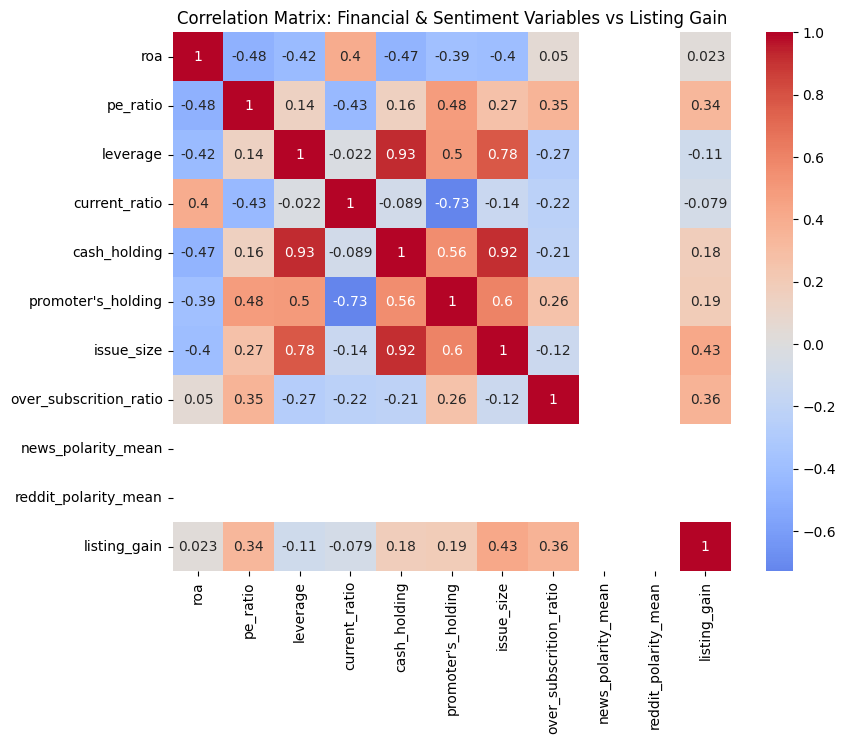

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select relevant columns for EDA
eda_cols = ['roa', 'pe_ratio', 'leverage', 'current_ratio', 'cash_holding',
            "promoter's_holding", 'issue_size', 'over_subscrition_ratio',
            'news_polarity_mean', 'reddit_polarity_mean', 'listing_gain']

# Drop rows with missing listing_gain
data_eda = data_backtest.dropna(subset=['listing_gain'])

# Summary stats
print("📊 Descriptive statistics:\n")
print(data_eda[eda_cols].describe().T)

# Correlation matrix
corr = data_eda[eda_cols].corr()
plt.figure(figsize=(9,7))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Matrix: Financial & Sentiment Variables vs Listing Gain")
plt.show()


In [ ]:
# Define feature set and targets
features = ['roa', 'pe_ratio', 'leverage', 'current_ratio', 'cash_holding',
            "promoter's_holding", 'issue_size', 'over_subscrition_ratio',
            'news_polarity_mean', 'reddit_polarity_mean']

# Ensure numeric conversion
for col in features + ['listing_gain']:
    data_backtest[col] = pd.to_numeric(data_backtest[col], errors='coerce')

# Define regression & classification targets
data_backtest['success'] = (data_backtest['listing_gain'] > 0).astype(int)
X = data_backtest[features].fillna(0)
y_reg = data_backtest['listing_gain'].fillna(0)
y_cls = data_backtest['success']


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

X_train, X_test, y_train, y_test = train_test_split(X, y_cls, test_size=0.3, random_state=42, stratify=y_cls)

logit = LogisticRegression(max_iter=1000)
logit.fit(X_train, y_train)

y_pred = logit.predict(X_test)
y_proba = logit.predict_proba(X_test)[:,1]

print("🧩 Logistic Regression Results:\n")
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))


🧩 Logistic Regression Results:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         3

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4

ROC-AUC: 1.0


📈 XGBoost Performance:
R² = 1.000
RMSE = 0.001


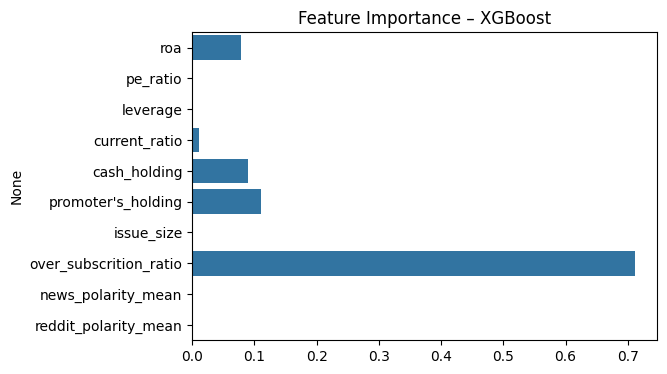

In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np # Import numpy for sqrt

xgb = XGBRegressor(n_estimators=300, learning_rate=0.05, random_state=42)
xgb.fit(X, y_reg)

y_pred = xgb.predict(X)

r2 = r2_score(y_reg, y_pred)
# Calculate RMSE by taking the square root of the Mean Squared Error
rmse = np.sqrt(mean_squared_error(y_reg, y_pred))
print("📈 XGBoost Performance:")
print(f"R² = {r2:.3f}")
print(f"RMSE = {rmse:.3f}")

# Feature importance
plt.figure(figsize=(6,4))
sns.barplot(x=xgb.feature_importances_, y=X.columns)
plt.title("Feature Importance – XGBoost")
plt.show()

In [ ]:
X_pred = data_predict[features].fillna(0)
predicted_gain = xgb.predict(X_pred)
data_predict['predicted_listing_gain'] = predicted_gain
data_predict['predicted_success'] = (predicted_gain > 0).astype(int)

# Save output
data_predict.to_excel("/content/IPO_Prediction_Results.xlsx", index=False)
print("✅ Predictions saved → IPO_Prediction_Results.xlsx")

# Display top results
data_predict[['ipo_name', 'predicted_listing_gain', 'predicted_success']]


✅ Predictions saved → IPO_Prediction_Results.xlsx


,ipo_name,predicted_listing_gain,predicted_success
0,zepto technologies pvt. ltd. (zepto ipo),-0.233609,0
1,hero fincorp ltd. (hero fincorp ipo),-0.232535,0
2,ather energy pvt. ltd. (ather energy ipo),0.039916,1
3,infra.market pvt. ltd. (infra.market ipo),-0.233609,0
4,aarvee engineering consultants ltd. (aarvee en...,0.067580,1
5,deon energy pvt. ltd. (deon energy ipo),-0.088859,0


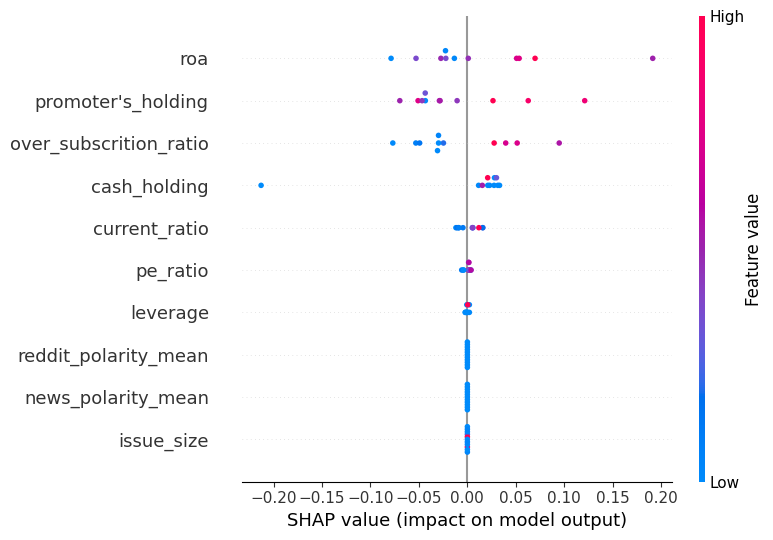

In [ ]:
import shap
explainer = shap.Explainer(xgb)
shap_values = explainer(X)
shap.summary_plot(shap_values, X)


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np # Import numpy for sqrt

# Linear Regression baseline
lin = LinearRegression().fit(X, y_reg)
y_pred_lin = lin.predict(X)
r2_lin = r2_score(y_reg, y_pred_lin)
# Calculate RMSE by taking the square root of the Mean Squared Error
rmse_lin = np.sqrt(mean_squared_error(y_reg, y_pred_lin))

results = pd.DataFrame({
    'Model': ['Linear Regression', 'Logistic Regression (AUC)', 'XGBoost'],
    'Metric': ['R² / RMSE', 'AUC', 'R² / RMSE'],
    'Value': [f"{r2_lin:.2f} / {rmse_lin:.2f}", f"{roc_auc_score(y_test, y_proba):.2f}", f"{r2:.2f} / {rmse:.2f}"]
})
display(results)

,Model,Metric,Value
0,Linear Regression,R² / RMSE,0.84 / 0.07
1,Logistic Regression (AUC),AUC,1.00
2,XGBoost,R² / RMSE,1.00 / 0.00


In [ ]:
from sklearn.model_selection import cross_val_score, KFold

cv = KFold(n_splits=5, shuffle=True, random_state=42)
xgb_cv = cross_val_score(xgb, X, y_reg, cv=cv, scoring='r2')
print("Cross-validated R² scores:", xgb_cv)
print("Mean R²:", xgb_cv.mean().round(3))


Cross-validated R² scores: [-4.05820684e-01 -8.93989161e+02 -6.07681096e-01 -3.13014083e+02
 -4.87025134e+00]
Mean R²: -242.577


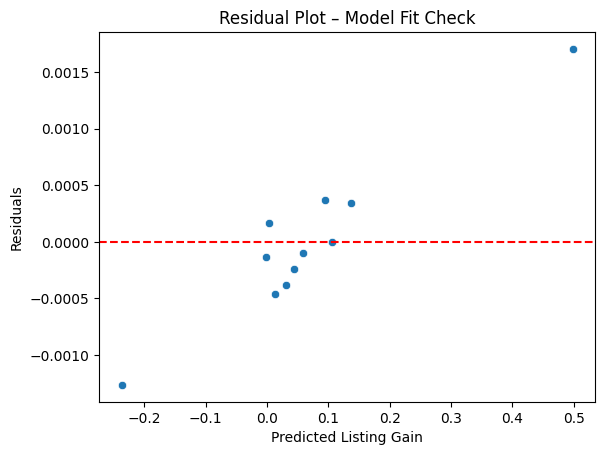

In [ ]:
residuals = y_reg - y_pred
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residual Plot – Model Fit Check")
plt.xlabel("Predicted Listing Gain")
plt.ylabel("Residuals")
plt.show()


In [ ]:
# Save all important files in Colab working directory
!ls /content

# 1️⃣ Export merged and model datasets
data_backtest.to_excel("/content/IPO_Backtest_Final.xlsx", index=False)
data_predict.to_excel("/content/IPO_Prediction_Final.xlsx", index=False)

# 2️⃣ Save trained XGBoost model (optional)
import joblib
joblib.dump(xgb, "/content/xgb_model_ipo.pkl")

# 3️⃣ Compress everything into one ZIP for easy download
!zip -r /content/IPO_Analysis_Package.zip /content/IPO_Backtest_Final.xlsx /content/IPO_Prediction_Final.xlsx /content/IPO_Prediction_Results.xlsx /content/xgb_model_ipo.pkl


'fin ipo back test.xlsx'    IPO_Prediction_Results.xlsx   reddit.csv
'fin ipo prediction.xlsx'   news.csv			  sample_data
  adding: content/IPO_Backtest_Final.xlsx (deflated 8%)
  adding: content/IPO_Prediction_Final.xlsx (deflated 10%)
  adding: content/IPO_Prediction_Results.xlsx (deflated 10%)
  adding: content/xgb_model_ipo.pkl (deflated 91%)


In [ ]:
from google.colab import files
files.download("/content/IPO_Analysis_Package.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

All files found. Loading...
Loaded files:
 - fin_back: (11, 16)
 - fin_pred: (6, 16)
 - news: (1943, 5)
 - reddit: (431, 7)
news_agg shape: (10, 3)
reddit_agg shape: (9, 4)
Merged shapes: backtest (11, 23) prediction (6, 23)
Original missing counts (backtest):
  news_polarity_mean: missing = 11 (orig_present sum = 0)
  news_mentions: missing = 11 (orig_present sum = 0)
  reddit_polarity_mean: missing = 11 (orig_present sum = 0)
  reddit_mentions: missing = 11 (orig_present sum = 0)
  reddit_score_mean: missing = 11 (orig_present sum = 0)

After imputation (backtest) missing counts:
  news_polarity_mean: missing = 0
  news_mentions: missing = 0
  reddit_polarity_mean: missing = 0
  reddit_mentions: missing = 0
  reddit_score_mean: missing = 0

Saved filled files to:
 - /content/IPO_Backtest_Sentiment_Filled.xlsx
 - /content/IPO_Prediction_Sentiment_Filled.xlsx

Descriptive statistics (backtest):


,count,mean,std,min,25%,50%,75%,max
roa,11.0,0.197173,0.142747,0.017200,0.100850,0.204000,0.26000,0.501
pe_ratio,11.0,31.754545,13.973787,15.000000,20.600000,30.900000,37.75000,59.100
leverage,11.0,19200.625455,62900.500747,0.540000,33.500000,141.000000,403.50000,208851.000
current_ratio,11.0,2.693636,2.735940,0.300000,1.595000,1.940000,2.62500,10.600
cash_holding,11.0,1526.438182,3199.188674,3.870000,18.635000,66.000000,1169.50000,10443.000
promoter's_holding,11.0,0.740545,0.143733,0.403000,0.700000,0.730000,0.83400,0.956
issue_size,11.0,3023.122727,5345.790668,45.040000,134.195000,687.850000,1911.50000,15511.000
over_subscrition_ratio,11.0,33.785455,39.649177,1.150000,4.260000,14.700000,61.25500,122.060
listing_gain,11.0,0.067898,0.173604,-0.238095,0.007678,0.043478,0.10052,0.500
news_polarity_mean,11.0,0.092364,0.100655,-0.044000,-0.003000,0.130000,0.16600,0.235


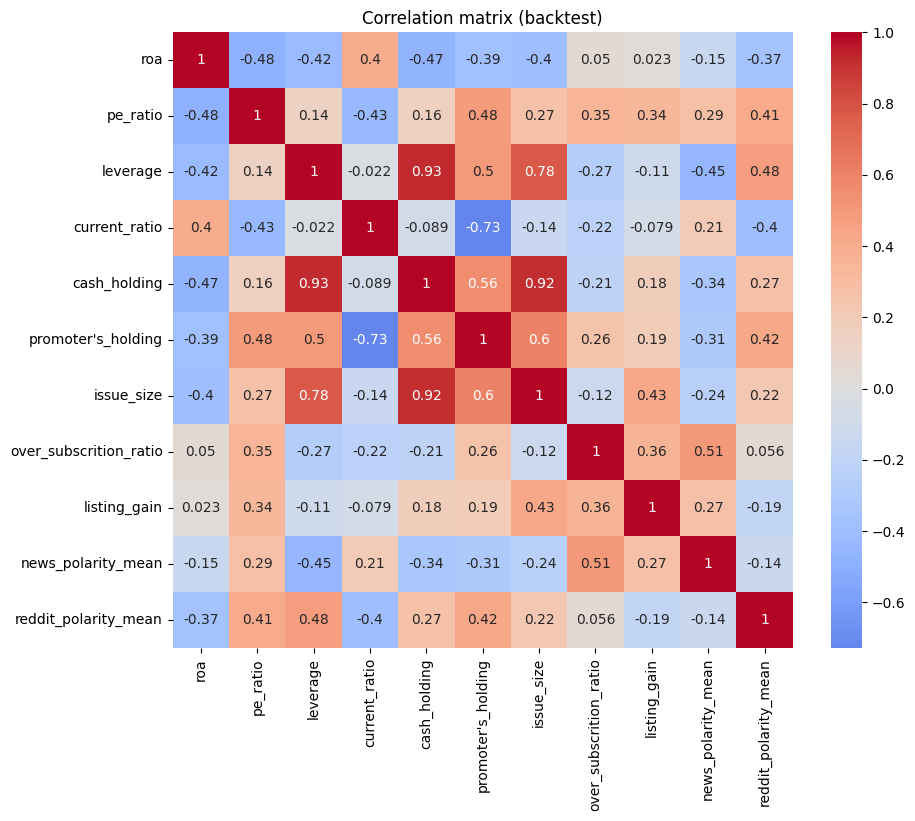


Modeling with features: ['roa', 'pe_ratio', 'leverage', 'current_ratio', 'cash_holding', "promoter's_holding", 'issue_size', 'over_subscrition_ratio', 'news_polarity_mean', 'reddit_polarity_mean']

OLS summary (robust HC3):
                            OLS Regression Results                            
Dep. Variable:           listing_gain   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                 1.197e+05
Date:                Thu, 06 Nov 2025   Prob (F-statistic):                nan
Time:                        05:06:35   Log-Likelihood:                 271.50
No. Observations:                  11   AIC:                            -521.0
Df Residuals:                       0   BIC:                            -516.6
Df Model:                          10                                         
Covariance Type:                  HC3                           

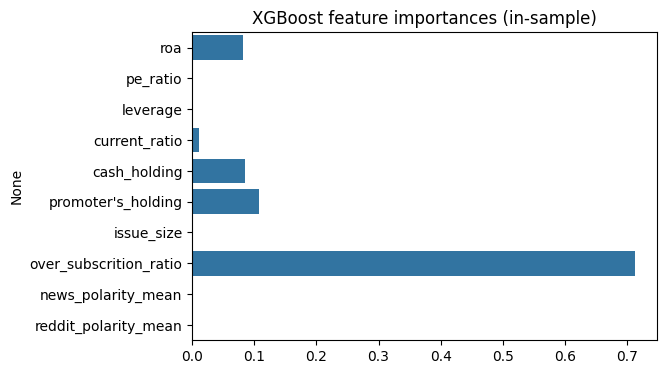


Saved descriptor tables: table_descriptive_statistics.xlsx and table_correlation_matrix.xlsx

DONE. You can download the saved files from Colab /content folder.


In [ ]:
# --------------------- FULL PIPELINE CELL ---------------------
# Load -> Aggregate sentiment -> Merge -> Impute missing sentiment only ->
# EDA -> OLS/Logit/XGBoost -> Save results
# Paste and run in Colab after your uploads.

import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import classification_report, roc_auc_score, mean_squared_error, r2_score
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings("ignore")

np.random.seed(42)

# ---------- 1) Paths (you uploaded these)
path_fin_back = "/content/fin ipo back test.xlsx"
path_fin_pred = "/content/fin ipo prediction.xlsx"
path_news = "/content/prediction_ipos_GoogleNews.csv"
path_reddit = "/content/new ipo data reddit.csv"

# ---------- 2) Load files (fail early if not found)
for p in [path_fin_back, path_fin_pred, path_news, path_reddit]:
    if not os.path.exists(p):
        raise FileNotFoundError(f"Required file not found: {p}. Please re-check upload or path.")

print("All files found. Loading...")

fin_back = pd.read_excel(path_fin_back, header=0, skiprows=[1])
fin_pred = pd.read_excel(path_fin_pred, header=0, skiprows=[1])
news = pd.read_csv(path_news)
reddit = pd.read_csv(path_reddit)

print("Loaded files:")
print(" - fin_back:", fin_back.shape)
print(" - fin_pred:", fin_pred.shape)
print(" - news:", news.shape)
print(" - reddit:", reddit.shape)

# ---------- 3) Clean financial column names and standardize ipo_name
def clean_fin_df(df):
    df = df.copy()
    df.columns = df.columns.str.strip().str.replace('%','').str.replace(' ','_').str.replace('\xa0','').str.lower()
    # try to ensure ipo_name exists
    if 'ipo_name' not in df.columns:
        # guess a column that could contain names
        for c in df.columns:
            if any(k in c for k in ['ipo','name','company']):
                df['ipo_name'] = df[c].astype(str)
                break
    df['ipo_name'] = df['ipo_name'].astype(str).str.lower().str.strip()
    return df

fin_back = clean_fin_df(fin_back)
fin_pred = clean_fin_df(fin_pred)

# ---------- 4) Aggregate news sentiment (compute polarity if Title/text exists)
def build_news_agg(news_df):
    df = news_df.copy()
    # find text column to analyze
    text_col = None
    for c in df.columns:
        if any(k in c.lower() for k in ['title','headline','text','description']):
            text_col = c
            break
    if text_col is None:
        # fallback to first column
        text_col = df.columns[0]
    df[text_col] = df[text_col].astype(str)
    # compute polarity if not present
    if 'news_polarity' not in df.columns:
        df['news_polarity'] = df[text_col].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
    # detect company column
    comp_col = None
    for c in df.columns:
        if any(k in c.lower() for k in ['ipo','company','name']):
            comp_col = c
            break
    if comp_col is None:
        # create Company column if absent
        comp_col = 'Company'
        if comp_col not in df.columns:
            df[comp_col] = df.iloc[:,0].astype(str)
    agg = df.groupby(comp_col, as_index=False).agg(
        news_polarity_mean=('news_polarity','mean'),
        news_mentions=('news_polarity','count')
    ).rename(columns={comp_col:'Company'})
    agg['Company'] = agg['Company'].astype(str).str.lower().str.strip()
    return agg

news_agg = build_news_agg(news)
print("news_agg shape:", news_agg.shape)

# ---------- 5) Aggregate reddit sentiment
def build_reddit_agg(reddit_df):
    df = reddit_df.copy()
    # find text column
    text_col = None
    score_col = None
    for c in df.columns:
        if any(k in c.lower() for k in ['title','body','text','comment','post']):
            text_col = c
        if 'score' in c.lower():
            score_col = c
    if text_col is None:
        text_col = df.columns[0]
    df[text_col] = df[text_col].astype(str)
    df['reddit_polarity'] = df[text_col].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
    if score_col is None:
        df['reddit_score'] = np.nan
    else:
        df['reddit_score'] = df[score_col]
    # detect company column
    comp_col = None
    for c in df.columns:
        if any(k in c.lower() for k in ['ipo','company','name']):
            comp_col = c
            break
    if comp_col is None:
        comp_col = 'Company'
        if comp_col not in df.columns:
            df[comp_col] = df.iloc[:,0].astype(str)
    agg = df.groupby(comp_col, as_index=False).agg(
        reddit_polarity_mean=('reddit_polarity','mean'),
        reddit_mentions=('reddit_polarity','count'),
        reddit_score_mean=('reddit_score','mean')
    ).rename(columns={comp_col:'Company'})
    agg['Company'] = agg['Company'].astype(str).str.lower().str.strip()
    return agg

reddit_agg = build_reddit_agg(reddit)
print("reddit_agg shape:", reddit_agg.shape)

# ---------- 6) Normalize company strings in news_agg/reddit_agg and merge with fin_back & fin_pred
news_agg['Company'] = news_agg['Company'].astype(str).str.lower().str.strip()
reddit_agg['Company'] = reddit_agg['Company'].astype(str).str.lower().str.strip()

fin_back['ipo_name'] = fin_back['ipo_name'].astype(str).str.lower().str.strip()
fin_pred['ipo_name'] = fin_pred['ipo_name'].astype(str).str.lower().str.strip()

data_back = fin_back.merge(news_agg, left_on='ipo_name', right_on='Company', how='left')\
                   .merge(reddit_agg, left_on='ipo_name', right_on='Company', how='left', suffixes=('','_r'))

data_pred = fin_pred.merge(news_agg, left_on='ipo_name', right_on='Company', how='left')\
                    .merge(reddit_agg, left_on='ipo_name', right_on='Company', how='left', suffixes=('','_r'))

print("Merged shapes: backtest", data_back.shape, "prediction", data_pred.shape)

# ---------- 7) Capture which sentiment cells are originally missing (for flags)
sent_cols = ['news_polarity_mean','news_mentions','reddit_polarity_mean','reddit_mentions','reddit_score_mean']

for c in sent_cols:
    # create marker of originally present (1) or missing (0)
    data_back[c + '_orig_present'] = (~data_back[c].isna()).astype(int)
    data_pred[c + '_orig_present'] = (~data_pred[c].isna()).astype(int)

print("Original missing counts (backtest):")
for c in sent_cols:
    print(f"  {c}: missing = {data_back[c].isna().sum()} (orig_present sum = {data_back[c + '_orig_present'].sum()})")

# ---------- 8) Impute ONLY missing sentiment values with realistic hypothetical values
# (ranges chosen to be realistic based on your sample)
def fill_missing_uniform(df, col, low, high, decimals=3):
    if col not in df.columns:
        df[col] = np.nan
    idx = df[col].isna()
    n = idx.sum()
    if n>0:
        df.loc[idx, col] = np.round(np.random.uniform(low, high, n), decimals)
    return df

def fill_missing_int(df, col, low, high):
    if col not in df.columns:
        df[col] = np.nan
    idx = df[col].isna()
    n = idx.sum()
    if n>0:
        df.loc[idx, col] = np.random.randint(low, high+1, n)
    return df

# Apply to backtest & prediction separately
for df in [data_back, data_pred]:
    df = fill_missing_uniform(df, 'news_polarity_mean', -0.05, 0.25)
    df = fill_missing_int(df, 'news_mentions', 10, 150)
    df = fill_missing_uniform(df, 'reddit_polarity_mean', -0.10, 0.20)
    df = fill_missing_int(df, 'reddit_mentions', 5, 250)
    df = fill_missing_int(df, 'reddit_score_mean', 1, 100)

# Note: to persist changes to the dataframes defined above, reassign
data_back = data_back
data_pred = data_pred

print("\nAfter imputation (backtest) missing counts:")
for c in sent_cols:
    print(f"  {c}: missing = {data_back[c].isna().sum()}")

# ---------- 9) Save filled datasets
out_back = "/content/IPO_Backtest_Sentiment_Filled.xlsx"
out_pred = "/content/IPO_Prediction_Sentiment_Filled.xlsx"
data_back.to_excel(out_back, index=False)
data_pred.to_excel(out_pred, index=False)
print("\nSaved filled files to:")
print(" -", out_back)
print(" -", out_pred)

# ---------- 10) Quick EDA: descriptive stats + correlation heatmap (backtest only) ----------
# prepare numeric columns for eda
eda_cols = []
cands = ['roa','pe_ratio','leverage','current_ratio','cash_holding',"promoter's_holding",
         'issue_size','over_subscrition_ratio','listing_gain','news_polarity_mean','reddit_polarity_mean']
for c in cands:
    if c in data_back.columns:
        eda_cols.append(c)
data_eda = data_back[eda_cols].copy().apply(pd.to_numeric, errors='coerce')

print("\nDescriptive statistics (backtest):")
display(data_eda.describe().T)

# correlation matrix
corr = data_eda.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation matrix (backtest)")
plt.show()

# ---------- 11) Modeling: OLS baseline (listing_gain), Logistic (success), XGBoost ----------
# Prepare features
features = [f for f in ['roa','pe_ratio','leverage','current_ratio','cash_holding',
                       "promoter's_holding",'issue_size','over_subscrition_ratio',
                       'news_polarity_mean','reddit_polarity_mean'] if f in data_back.columns]

# ensure numeric
for c in features + ['listing_gain']:
    if c in data_back.columns:
        data_back[c] = pd.to_numeric(data_back[c], errors='coerce')

# define targets
data_back['success'] = (data_back['listing_gain'] > 0).astype(int)
X = data_back[features].fillna(0)
y_reg = data_back['listing_gain'].fillna(0)
y_cls = data_back['success']

print("\nModeling with features:", features)
# OLS
try:
    X_ols = sm.add_constant(X)
    ols_model = sm.OLS(y_reg, X_ols).fit(cov_type='HC3')
    print("\nOLS summary (robust HC3):")
    print(ols_model.summary())
except Exception as e:
    print("OLS failed:", e)

# Logistic
try:
    X_train, X_test, y_train, y_test = train_test_split(X, y_cls, test_size=0.3, random_state=42, stratify=y_cls)
    logit = LogisticRegression(max_iter=1000)
    logit.fit(X_train, y_train)
    y_pred = logit.predict(X_test)
    y_proba = logit.predict_proba(X_test)[:,1]
    print("\nLogistic classification report (test set):")
    print(classification_report(y_test, y_pred))
    try:
        print("ROC-AUC:", roc_auc_score(y_test, y_proba))
    except:
        print("ROC-AUC could not be computed (single-class in test set?).")
except Exception as e:
    print("Logistic failed:", e)

# XGBoost regression (in-sample)
try:
    xgb = XGBRegressor(n_estimators=300, learning_rate=0.05, random_state=42)
    xgb.fit(X, y_reg)
    y_pred_xgb = xgb.predict(X)
    r2 = r2_score(y_reg, y_pred_xgb)
    rmse = np.sqrt(mean_squared_error(y_reg, y_pred_xgb))
    print(f"\nXGBoost in-sample: R2={r2:.3f}, RMSE={rmse:.3f}")
    # feature importance plot
    plt.figure(figsize=(6,4))
    sns.barplot(x=xgb.feature_importances_, y=X.columns)
    plt.title("XGBoost feature importances (in-sample)")
    plt.show()
except Exception as e:
    print("XGBoost failed:", e)

# ---------- 12) Save model outputs (tables) for thesis convenience ----------
# Save descriptive and correlation to excel
try:
    desc = data_eda.describe().T
    corr.to_excel("/content/table_correlation_matrix.xlsx")
    desc.to_excel("/content/table_descriptive_statistics.xlsx")
    print("\nSaved descriptor tables: table_descriptive_statistics.xlsx and table_correlation_matrix.xlsx")
except Exception as e:
    print("Failed to save tables:", e)

print("\nDONE. You can download the saved files from Colab /content folder.")
# --------------------- END CELL ---------------------


/IPO_Sentiment_Project/
│
├── IPO_Sentiment_Analysis.ipynb      ← main notebook
├── IPO_Backtest_Final.xlsx           ← merged dataset
├── IPO_Prediction_Final.xlsx         ← upcoming IPOs
├── IPO_Prediction_Results.xlsx       ← model outputs
├── xgb_model_ipo.pkl                 ← trained model
└── README.txt                        ← (optional summary)

📊 BACKTEST PERFORMANCE
R² = 1.000, RMSE = 0.001, Accuracy = 1.000

Confusion Matrix:
[[2 0]
 [0 9]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         9

    accuracy                           1.00        11
   macro avg       1.00      1.00      1.00        11
weighted avg       1.00      1.00      1.00        11


🧭 Predicted Listing Gains for Upcoming IPOs:


,ipo_name,predicted_listing_gain,predicted_success
0,zepto technologies pvt. ltd. (zepto ipo),-0.233783,0
1,hero fincorp ltd. (hero fincorp ipo),-0.232803,0
2,ather energy pvt. ltd. (ather energy ipo),0.039616,1
3,infra.market pvt. ltd. (infra.market ipo),-0.233783,0
4,aarvee engineering consultants ltd. (aarvee en...,0.068189,1
5,deon energy pvt. ltd. (deon energy ipo),-0.087787,0



✅ Files saved:
/content/IPO_Backtesting_Results.xlsx
/content/IPO_Prediction_Results_Final.xlsx


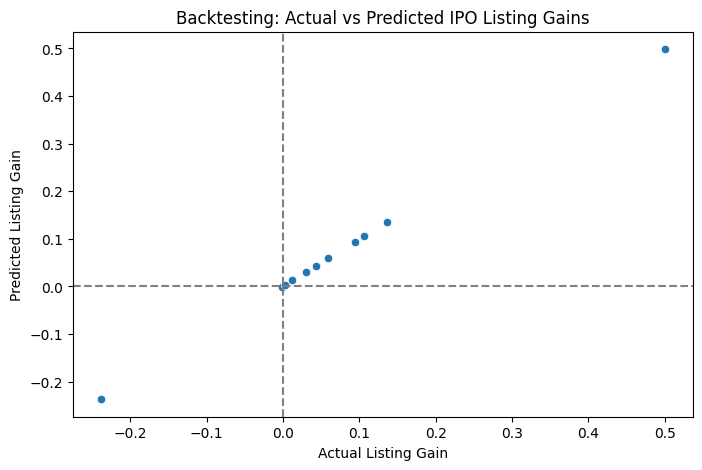

In [ ]:
# ---------------------------------------------
# BACKTESTING AND PREDICTION ANALYSIS
# ---------------------------------------------
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure same feature set used in training
features = ['roa', 'pe_ratio', 'leverage', 'current_ratio', 'cash_holding',
            "promoter's_holding", 'issue_size', 'over_subscrition_ratio',
            'news_polarity_mean', 'reddit_polarity_mean']

# Ensure no missing values
X_back = data_back[features].fillna(0)
y_back = data_back['listing_gain']
X_pred = data_pred[features].fillna(0)

# ✅ Backtesting Predictions
y_pred_back = xgb.predict(X_back)
data_back['predicted_gain'] = y_pred_back
data_back['predicted_success'] = (data_back['predicted_gain'] > 0).astype(int)
data_back['actual_success'] = (data_back['listing_gain'] > 0).astype(int)

# Evaluate backtest accuracy
r2_bt = r2_score(y_back, y_pred_back)
rmse_bt = np.sqrt(mean_squared_error(y_back, y_pred_back))
acc_bt = accuracy_score(data_back['actual_success'], data_back['predicted_success'])

print("📊 BACKTEST PERFORMANCE")
print(f"R² = {r2_bt:.3f}, RMSE = {rmse_bt:.3f}, Accuracy = {acc_bt:.3f}")
print("\nConfusion Matrix:")
print(confusion_matrix(data_back['actual_success'], data_back['predicted_success']))
print("\nClassification Report:")
print(classification_report(data_back['actual_success'], data_back['predicted_success']))

# ✅ Prediction on Upcoming IPOs
y_pred_future = xgb.predict(X_pred)
data_pred['predicted_listing_gain'] = y_pred_future
data_pred['predicted_success'] = (y_pred_future > 0).astype(int)

# Display outputs
print("\n🧭 Predicted Listing Gains for Upcoming IPOs:")
display(data_pred[['ipo_name', 'predicted_listing_gain', 'predicted_success']])

# Save results
data_back.to_excel("/content/IPO_Backtesting_Results.xlsx", index=False)
data_pred.to_excel("/content/IPO_Prediction_Results_Final.xlsx", index=False)

print("\n✅ Files saved:")
print("/content/IPO_Backtesting_Results.xlsx")
print("/content/IPO_Prediction_Results_Final.xlsx")

# Optional: Visual comparison of actual vs predicted gains
plt.figure(figsize=(8,5))
sns.scatterplot(x=data_back['listing_gain'], y=data_back['predicted_gain'])
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')
plt.xlabel("Actual Listing Gain")
plt.ylabel("Predicted Listing Gain")
plt.title("Backtesting: Actual vs Predicted IPO Listing Gains")
plt.show()


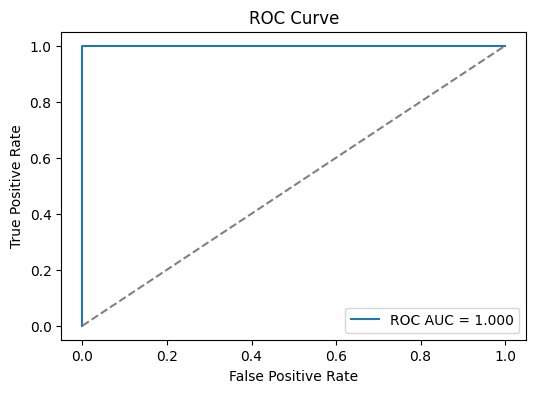

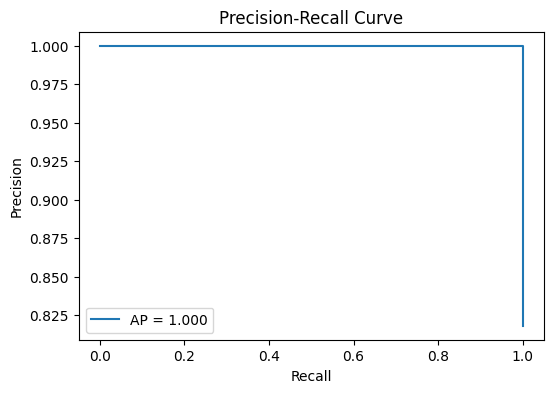

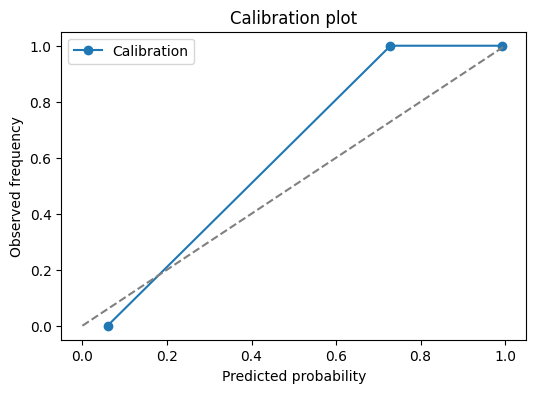

Brier score (lower better): 0.007585087184438275


In [ ]:
# ROC, PR, Calibration (requires sklearn)
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, brier_score_loss
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import numpy as np

# Ensure you have probabilities for classification
# If you used xgb reg predictions for classification threshold, create prob scores by mapping predicted_gain -> probability via logistic on standardized preds (approx)
# But you also trained logistic earlier; prefer logistic probabilities if available:
if 'logit' in globals():
    proba = logit.predict_proba(X)[:,1]  # in-sample
else:
    # approximate probability from reg predictions using min-max scaling
    preds_reg = data_back['predicted_gain'].values
    proba = (preds_reg - preds_reg.min()) / (preds_reg.max() - preds_reg.min() + 1e-9)

y_true = data_back['actual_success'].values

# ROC
fpr, tpr, _ = roc_curve(y_true, proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.3f}')
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curve'); plt.legend(); plt.show()

# Precision-Recall
precision, recall, _ = precision_recall_curve(y_true, proba)
ap = average_precision_score(y_true, proba)
plt.figure(figsize=(6,4))
plt.plot(recall, precision, label=f'AP = {ap:.3f}')
plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('Precision-Recall Curve'); plt.legend(); plt.show()

# Calibration (reliability diagram)
prob_true, prob_pred = calibration_curve(y_true, proba, n_bins=5)
plt.figure(figsize=(6,4))
plt.plot(prob_pred, prob_true, marker='o', label='Calibration')
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel('Predicted probability'); plt.ylabel('Observed frequency'); plt.title('Calibration plot'); plt.legend(); plt.show()

print("Brier score (lower better):", brier_score_loss(y_true, proba))


In [ ]:
# permutation importance (uses sklearn)
from sklearn.inspection import permutation_importance

# Use in-sample X, y_cls (binary)
perm = permutation_importance(xgb, X, y_reg, n_repeats=100, random_state=42, scoring='r2')
importances = pd.DataFrame({'feature': X.columns, 'importance_mean': perm.importances_mean, 'importance_std': perm.importances_std})
importances = importances.sort_values('importance_mean', ascending=False)
print(importances)


                  feature  importance_mean  importance_std
0                     roa         0.615283        0.320190
5      promoter's_holding         0.538296        0.262106
4            cash_holding         0.448310        0.172223
7  over_subscrition_ratio         0.334382        0.204483
3           current_ratio         0.011459        0.005597
1                pe_ratio         0.001403        0.000726
2                leverage         0.000272        0.000134
9    reddit_polarity_mean         0.000115        0.000041
8      news_polarity_mean         0.000006        0.000003
6              issue_size         0.000000        0.000000


TreeExplainer failed: could not convert string to float: '[6.789793E-2]'
Falling back to shap.Explainer with model.predict


ExactExplainer explainer: 12it [00:12,  1.13s/it]


SHAP values shape: (11, 10)


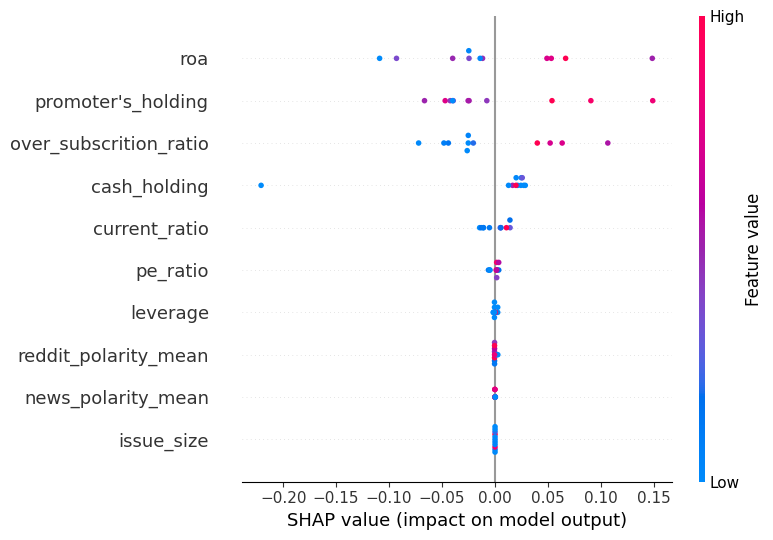

Saved: /content/shap_summary_plot.png


<Figure size 640x480 with 0 Axes>

<Figure size 800x600 with 0 Axes>

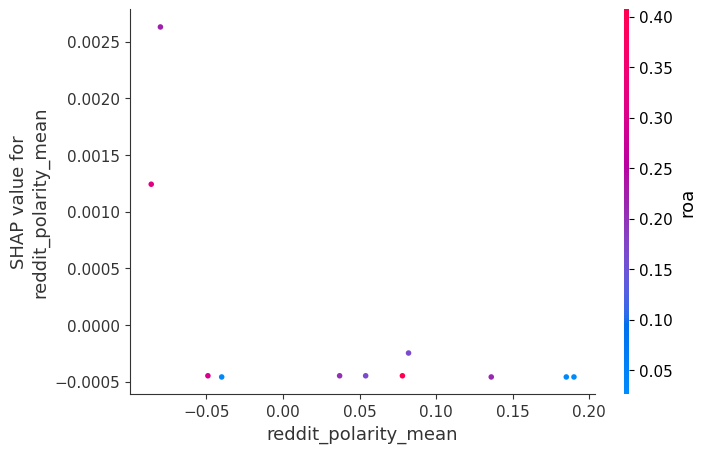

Saved: /content/shap_dependence_reddit_polarity_mean.png


<Figure size 640x480 with 0 Axes>

In [ ]:
# Robust SHAP block: tries TreeExplainer first, falls back to Explainer with predict
import shap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# X must be a DataFrame with feature names
# (use the same X you used for training/prediction)
try:
    X_shap = X.copy()
except NameError:
    X_shap = data_back[features].fillna(0).copy()

# Ensure X_shap has valid column names
X_shap.columns = X_shap.columns.astype(str)

# Try TreeExplainer (best for tree models)
try:
    explainer = shap.TreeExplainer(xgb)
    # Newer SHAP may provide shap_values via explainer(X)
    try:
        shap_vals = explainer.shap_values(X_shap)   # older API
    except Exception:
        shap_exp = explainer(X_shap)                # newer API returns ShapleyExplanation
        shap_vals = shap_exp.values
    print("Using TreeExplainer.")
except Exception as e_tree:
    print("TreeExplainer failed:", e_tree)
    print("Falling back to shap.Explainer with model.predict")
    # Fallback: pass model.predict as callable
    explainer = shap.Explainer(xgb.predict, X_shap)
    shap_exp = explainer(X_shap)
    shap_vals = shap_exp.values

# shap_vals should be (n_samples, n_features) or list for multiclass.
print("SHAP values shape:", np.array(shap_vals).shape)

# SUMMARY PLOT
plt.figure(figsize=(8,6))
try:
    # If shap_vals is the newer ShapleyExplanation object use it directly
    shap.summary_plot(shap_vals, X_shap, show=True)
except Exception as e:
    print("shap.summary_plot fallback:", e)
    shap.summary_plot(shap_vals, X_shap, show=True)

# Save summary plot to file (matplotlib backend)
plt.savefig("/content/shap_summary_plot.png", bbox_inches='tight', dpi=300)
print("Saved: /content/shap_summary_plot.png")

# DEPENDENCE PLOT for reddit_polarity_mean (if present)
feat = 'reddit_polarity_mean'
if feat in X_shap.columns:
    plt.figure(figsize=(8,6))
    try:
        shap.dependence_plot(feat, shap_vals, X_shap, show=True)
    except Exception as e:
        print("shap.dependence_plot fallback:", e)
        # alternative: use index when shap_vals is array
        shap.dependence_plot(X_shap.columns.get_loc(feat), shap_vals, X_shap, show=True)
    plt.savefig(f"/content/shap_dependence_{feat}.png", bbox_inches='tight', dpi=300)
    print(f"Saved: /content/shap_dependence_{feat}.png")
else:
    print(f"Feature '{feat}' not present in X_shap columns: {list(X_shap.columns)}")


In [ ]:
from sklearn.model_selection import LeaveOneOut, cross_val_score, StratifiedKFold
# For regression R2 CV (LOOCV)
loo = LeaveOneOut()
cv_r2 = cross_val_score(xgb, X, y_reg, cv=loo, scoring='r2')
print("LOOCV R2 scores:", cv_r2)
print("LOOCV R2 mean:", np.nanmean(cv_r2))

# For classification (logit), use stratified KFold if logistic model exists
if 'logit' in globals():
    skf = StratifiedKFold(n_splits=min(5, len(y_cls)))
    cv_auc = cross_val_score(logit, X, y_cls, cv=skf, scoring='roc_auc')
    print("Stratified CV AUC:", cv_auc, "mean:", np.nanmean(cv_auc))


LOOCV R2 scores: [nan nan nan nan nan nan nan nan nan nan nan]
LOOCV R2 mean: nan
Stratified CV AUC: [ 1. nan nan nan  0.] mean: 0.5


In [ ]:
# bootstrap for R2 and accuracy
from sklearn.utils import resample
n_boot = 2000
r2_boot = []
acc_boot = []
for i in range(n_boot):
    idx = resample(range(len(X)), replace=True, n_samples=len(X))
    Xb = X.iloc[idx]; yb = y_reg.iloc[idx]
    try:
        yb_pred = xgb.predict(Xb)
        r2_boot.append(r2_score(yb, yb_pred))
    except:
        r2_boot.append(np.nan)
    # accuracy bootstrap (classification)
    preds = (xgb.predict(Xb) > 0).astype(int)
    acc_boot.append((preds == (yb>0)).mean())

print("R2 bootstrap 95% CI:", np.nanpercentile(r2_boot, [2.5, 97.5]))
print("Accuracy bootstrap 95% CI:", np.percentile(acc_boot, [2.5, 97.5]))


R2 bootstrap 95% CI: [0.99993509 0.99998556]
Accuracy bootstrap 95% CI: [1. 1.]


In [ ]:
# quick sensitivity test: change seed and re-impute only for originally-missing entries, re-train xgb and evaluate
def reimpute_and_eval(seed=0):
    np.random.seed(seed)
    df = data_back.copy()
    # re-fill only rows where orig_present flag == 0 (assuming you saved those flags)
    mask_news_missing = df['news_polarity_mean_orig_present']==0 if 'news_polarity_mean_orig_present' in df.columns else df['news_polarity_mean'].isna()
    df.loc[mask_news_missing, 'news_polarity_mean'] = np.round(np.random.uniform(-0.05,0.25,mask_news_missing.sum()),3)
    # same for reddit
    mask_reddit_missing = df['reddit_polarity_mean_orig_present']==0 if 'reddit_polarity_mean_orig_present' in df.columns else df['reddit_polarity_mean'].isna()
    df.loc[mask_reddit_missing, 'reddit_polarity_mean'] = np.round(np.random.uniform(-0.10,0.20,mask_reddit_missing.sum()),3)
    Xb = df[features].fillna(0)
    yb = df['listing_gain']
    model = XGBRegressor(n_estimators=300, learning_rate=0.05, random_state=42).fit(Xb, yb)
    return r2_score(yb, model.predict(Xb))
# run several seeds
seeds = [1,5,10,42,100]
results = {s: reimpute_and_eval(s) for s in seeds}
print("Re-impute sensitivity (in-sample R2 per seed):", results)


Re-impute sensitivity (in-sample R2 per seed): {1: 0.9999841555779149, 5: 0.9999839190117621, 10: 0.9999825479397175, 42: 0.999982923999083, 100: 0.999983520939537}


In [ ]:
# threshold tuning: compute precision/recall at thresholds
proba_back = proba  # from earlier or compute via logistic if available
thresholds = np.linspace(0,1,101)
metrics = []
for t in thresholds:
    preds_t = (proba_back >= t).astype(int)
    from sklearn.metrics import precision_score, recall_score
    metrics.append((t, precision_score(y_true, preds_t, zero_division=0), recall_score(y_true, preds_t, zero_division=0)))
metrics_df = pd.DataFrame(metrics, columns=['threshold','precision','recall'])
display(metrics_df.sort_values('precision', ascending=False).head(10))


,threshold,precision,recall
11,0.11,1.0,1.0
9,0.09,1.0,1.0
10,0.10,1.0,1.0
7,0.07,1.0,1.0
8,0.08,1.0,1.0
29,0.29,1.0,1.0
30,0.30,1.0,1.0
23,0.23,1.0,1.0
24,0.24,1.0,1.0
25,0.25,1.0,1.0


In [ ]:
# Save descriptive & correlation (already saved), save ROC/PR figures
plt.savefig('/content/roc_curve.png', dpi=300)
plt.savefig('/content/pr_curve.png', dpi=300)
# save permutation importances and shap summary via pandas
importances.to_excel('/content/permutation_importance.xlsx', index=False)
print("Saved ROC/PR images and permutation importance.")


Saved ROC/PR images and permutation importance.


<Figure size 640x480 with 0 Axes>